## Практическая работа №2
Необходимо с использованием результатов, полученных при выполнении Практической работы №1, спроектировать и реализовать прототип семантического анализатора естественного языка (Latent semantic analysis, LSA). Используйте векторы TF-IDF, векторы тем, стиринг и т.п.

In [2]:
import json
import re
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

### Загрузка ресурсов для NLTK

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\olegs\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olegs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\olegs\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Класс отчистки текста
Класс TextCleaner выполняет предобработку текстов песен, очищая их от лишних символов, пунктуации и стоп слов, а также приводя все слова к нижнему регистру и их базовой форме с помощью лемматизации. За счет этого тексты получаются унифицироваными и готовыми к дальнейшему векторному представлению и семантическому анализу.

In [4]:
class TextCleaner:
    _whitespace_re = re.compile(r"\s+")
    _non_alnum_re = re.compile(r"[^a-zA-Z0-9]")

    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text: str) -> str:
        text = self._whitespace_re.sub(" ", text)
        text = self._non_alnum_re.sub(" ", text)
        text = text.lower()
        words = word_tokenize(text)
        words = [self.lemmatizer.lemmatize(w) for w in words if w not in self.stop_words]
        return " ".join(words)

### Функция семантического анализа
Выполняет TF-IDF, LSA и расчёт косинусного сходства. Возвращает DataFrame с матрицей сходства.

In [5]:
def semantic_analysis(texts, titles, n_components=2, max_features=2000):
    # TF-IDF
    vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf_matrix = vectorizer.fit_transform(texts)

    # LSA
    lsa = TruncatedSVD(n_components=n_components, random_state=42)
    lsa_matrix = lsa.fit_transform(tfidf_matrix)

    # Косинусное сходство
    similarity_matrix = cosine_similarity(lsa_matrix)
    df_sim = pd.DataFrame(similarity_matrix, index=titles, columns=titles)
    return df_sim

### Функция визуализации
Строит тепловую карту семантической близости текстов.

In [6]:
def visualize_similarity(df_sim, title="Семантическое сходство текстов"):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_sim, cmap="YlGnBu", annot=True)
    plt.title(title)
    plt.show()

### Загрузка данных
Для создания набора данных использовалась программа реализованная в первом семестре в рамках курса "Технологии извлечения знаний". Данная программа позволяет парсить  информацию о композициях указанного артиста. Информация включает в себя: название, дату релиза, название альбома, просмотры страницы (на сайте Genius) и текст самой песни.


In [7]:
with open("ID_cleaned_songs.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)
print(f"Найдено песен: {len(df)}")
df.head()

Найдено песен: 100


,title,date,album_name,pageviews,lyrics
0,Believer,"February 1, 2017",Evolve (Japanese Edition),7988349,"Second things second, don't you tell me what y..."
1,Thunder,"April 27, 2017",Evolve (Japanese Edition),2557981,"Thunder, thunder, thunder, thun—\nThunder, th-..."
2,Demons,"January 23, 2013",Night Visions (Expanded Edition) [Super Deluxe],2252444,"I wanna hide the truth, I wanna shelter you\nB..."
3,Enemy,"October 28, 2021",Mercury - Acts 1 & 2 (Japanese Edition),1690764,I wake up to the sounds of the silence that al...
4,Radioactive,"February 14, 2012",Night Visions (Expanded Edition) [Super Deluxe],1681174,I'm waking up to ash and dust\nI wipe my brow ...


### Отчистка текста
Так как в рамках данной практической работы наc интересует текст самих песен и название альбома, то столбцы date и pageviews будут отчищены. 

In [8]:
cleandf = df.drop(['date', 'pageviews'], axis=1)

In [9]:
df = pd.DataFrame(cleandf)
cleaner = TextCleaner()
df["clean_lyrics"] = df["lyrics"].apply(cleaner.clean_text)
df.head()

,title,album_name,lyrics,clean_lyrics
0,Believer,Evolve (Japanese Edition),"Second things second, don't you tell me what y...",second thing second tell think could one sail ...
1,Thunder,Evolve (Japanese Edition),"Thunder, thunder, thunder, thun—\nThunder, th-...",thunder thunder thunder thun thunder th th thu...
2,Demons,Night Visions (Expanded Edition) [Super Deluxe],"I wanna hide the truth, I wanna shelter you\nB...",wan na hide truth wan na shelter beast inside ...
3,Enemy,Mercury - Acts 1 & 2 (Japanese Edition),I wake up to the sounds of the silence that al...,wake sound silence allows mind run around ear ...
4,Radioactive,Night Visions (Expanded Edition) [Super Deluxe],I'm waking up to ash and dust\nI wipe my brow ...,waking ash dust wipe brow sweat rust breathing...


### Семантический анализ текстов песен
В данном блоке проводится анализ 15 самых популярных песен

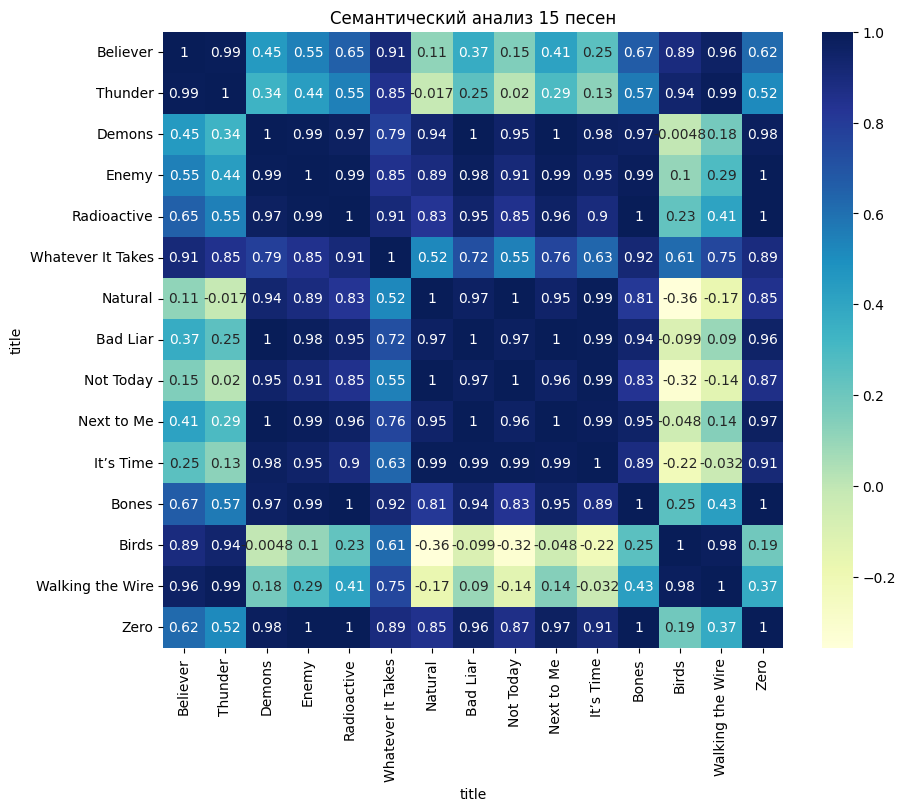

In [10]:
n_songs = 15
subset = df.head(n_songs)

df_sim = semantic_analysis(
    texts=subset["clean_lyrics"],
    titles=subset["title"]
)
df_sim.round(2)

visualize_similarity(df_sim, f"Семантический анализ {n_songs} песен")

### Семантический анализ песен с одного альбома
В данном блоке проводится анализ песен, принадлежащих к одному альбому

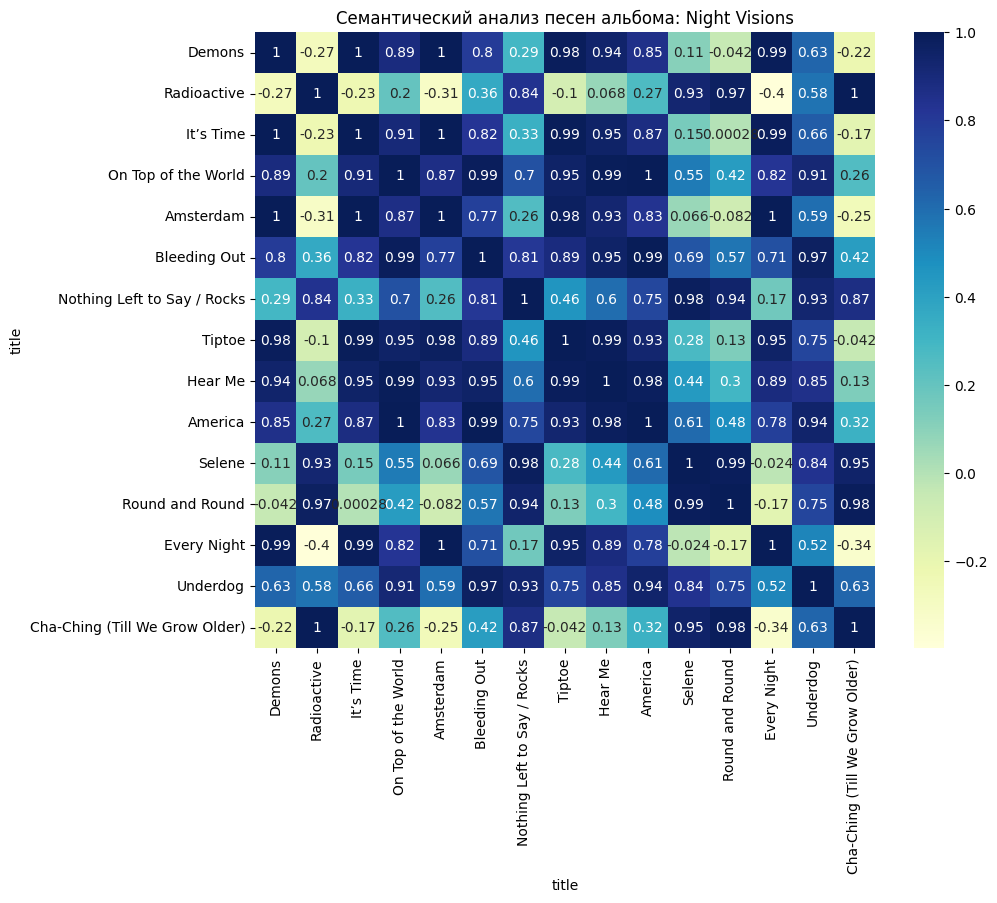

In [12]:
album_name = "Night Visions"
album_df = df[df["album_name"].str.contains(album_name, case=False, na=False)]

if not album_df.empty:
    df_album_sim = semantic_analysis(
        texts=album_df["clean_lyrics"],
        titles=album_df["title"]
    )
    visualize_similarity(df_album_sim, f"Семантический анализ песен альбома: {album_name}")
    
else:
    print(f"Альбом '{album_name}' не найден.")